#  Прогнозирование заказов такси
___

Cобраны исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо спрогнозировать количество заказов такси на следующий час. 

## Признаки

 - `datetime` - время заказа такси;
 
 
 - `num_orders` - количество заказов.

## Содержание
___

</span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-LGBMRegressor" data-toc-modified-id="Модель-LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель LGBMRegressor</a></span></li><li><span><a href="#Модель-CatBoostRegressor" data-toc-modified-id="Модель-CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a>

## Подготовка

Импортируем необходимые библиотеки:

In [6]:
import time

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

Прочитаем файл с данными, в качестве индекса укажем столбец с датами, а чтобы python определил их как даты, укажем параметр `parse_dates` = 0:

In [7]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные загружены, отсортируем их:

In [10]:
data.sort_index(inplace=True)

Проверим сортировку:

In [11]:
data.index.is_monotonic

True

Проверим, имеются ли в наших данных пропуски:

In [12]:
data.isna().sum()

num_orders    0
dtype: int64

Построим график количества заказов такси:

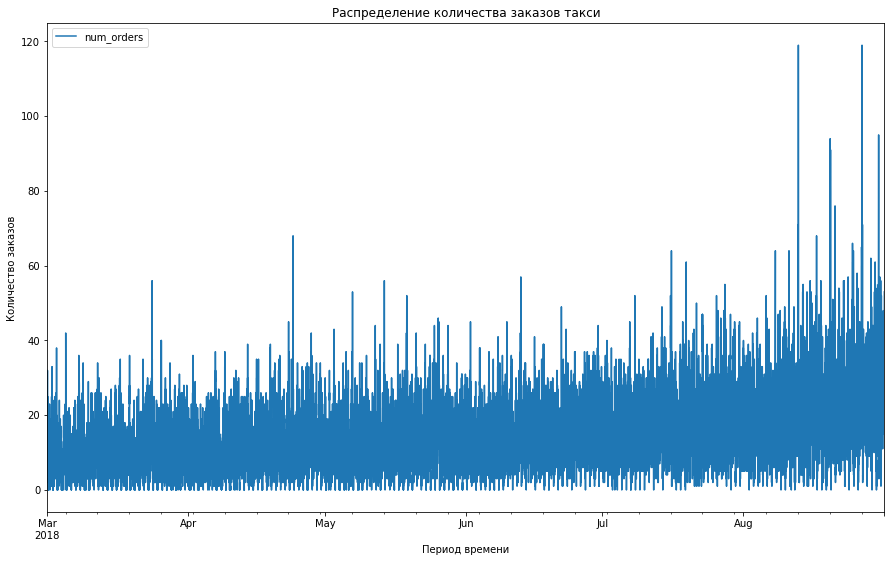

In [13]:
data.plot(figsize=(15,9))
plt.title('Распределение количества заказов такси')
plt.ylabel('Количество заказов')
plt.xlabel('Период времени')
plt.show()

Ресемплируем наши данные по одному часу:

In [14]:
data = data.resample('1H').sum()

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Количество наших данных изменилось, посмотрим на новый график:

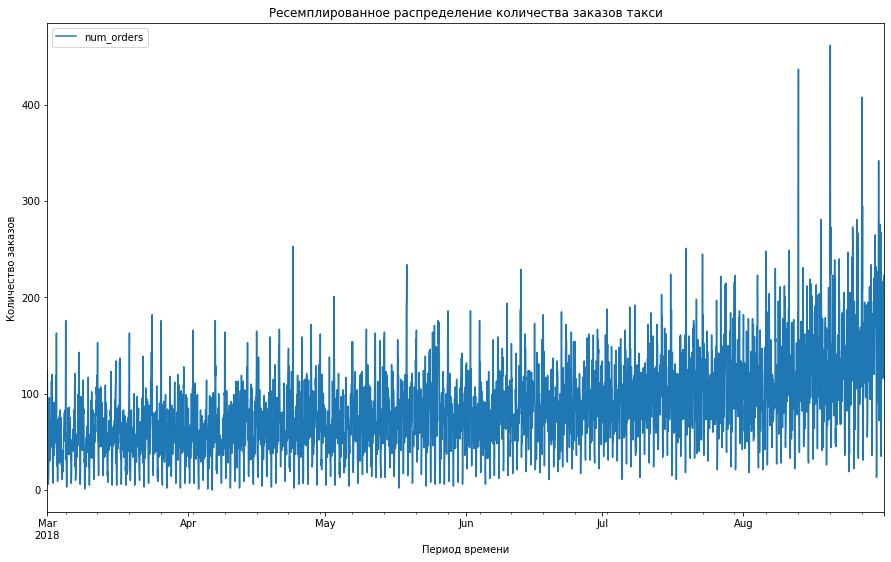

In [16]:
data.plot(figsize=(15,9))
plt.title('Ресемплированное распределение количества заказов такси')
plt.ylabel('Количество заказов')
plt.xlabel('Период времени')
plt.show()

Создадим функцию, которая будет брать исходный датасет и создавать столбцы признаков: `month`, `day`, `dayofweek`, `hour`, `lag` и `rolling_mean`:

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    
    new_data = data.copy()
    
    new_data['month'] = data.index.month
    new_data['day'] = data.index.day
    new_data['dayofweek'] = data.index.dayofweek
    new_data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    new_data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return new_data

Создадим новый датасет и посмотрим на него:

In [18]:
new_data = make_features(data, 3, 6)

In [19]:
new_data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,NaN


## Анализ
___

Разберем тренд и сезонность наших данных.

In [20]:
decomposed = seasonal_decompose(data)

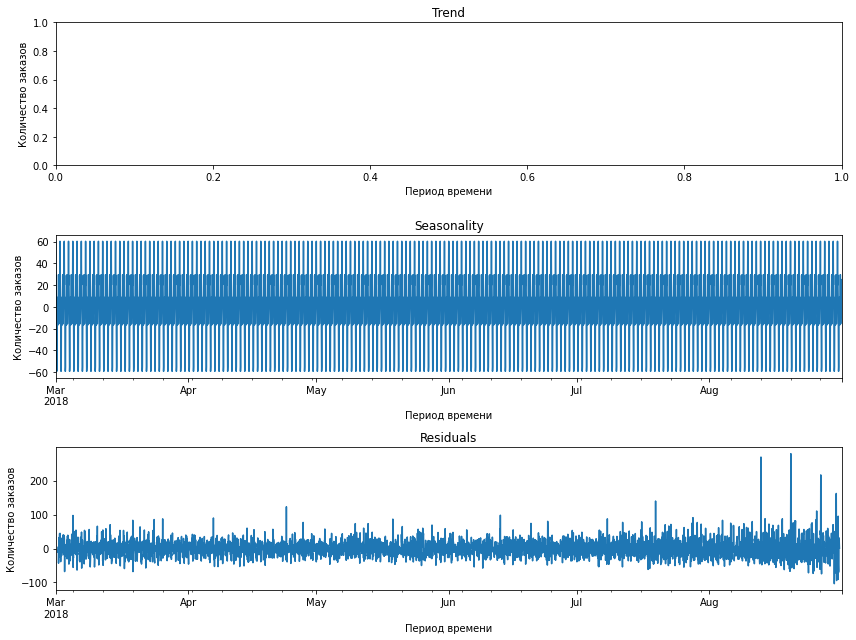

In [21]:
plt.figure(figsize=(12, 9))
decomposed.trend.plot(ax=plt.gca())
plt.subplot(311)
plt.title('Trend')
plt.ylabel('Количество заказов')
plt.xlabel('Период времени')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Количество заказов')
plt.xlabel('Период времени')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('Количество заказов')
plt.xlabel('Период времени')
plt.tight_layout()

Не слишком читаемые графики вышли, посмотрим на тренд и сезонность ресемплированных по дням данных:

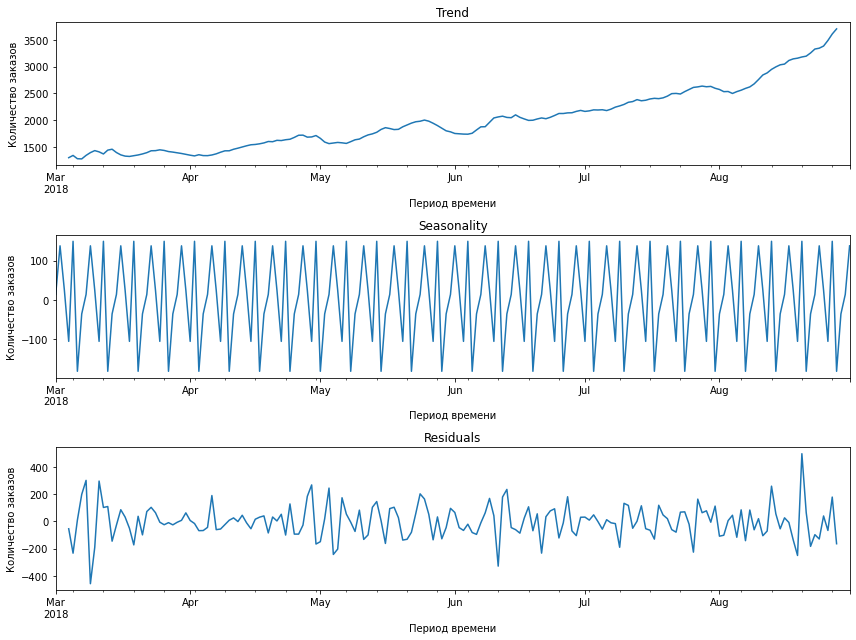

In [22]:
decomposed_day = seasonal_decompose(data.resample('1D').sum())
plt.figure(figsize=(12, 9))
plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Количество заказов')
plt.xlabel('Период времени')
plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Количество заказов')
plt.xlabel('Период времени')
plt.subplot(313)
decomposed_day.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('Количество заказов')
plt.xlabel('Период времени')
plt.tight_layout()

Как видно из построенных графиков количество заказов такси в аэропорт неуклонно растет, а сезонность зависит от дня недели. Чтобы лучше проследить сезонность заказов такси, построим график по недели:

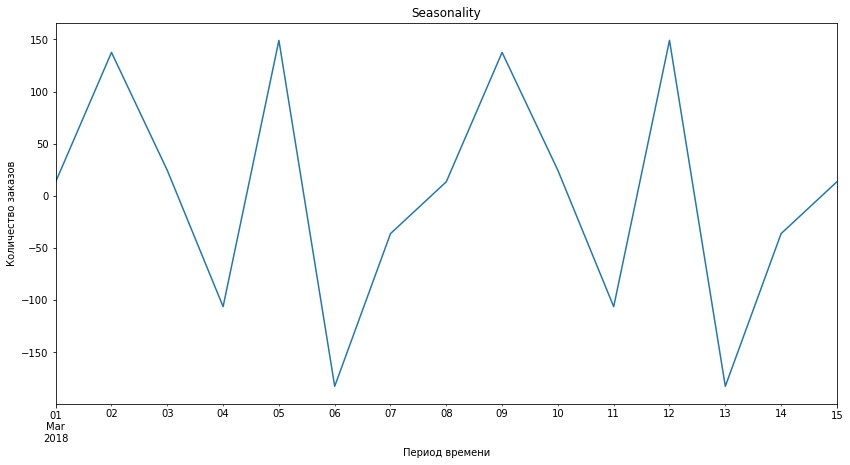

In [23]:
decomposed_day = seasonal_decompose(data.resample('1D').sum())

plt.figure(figsize=(14, 7))
decomposed_day.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Количество заказов')
plt.xlabel('Период времени')
plt.show()

Наиболее часто такси в аэропорт заказывают во вторник и пятницу.

Посмотрим на сезонность заказов в течение дня:

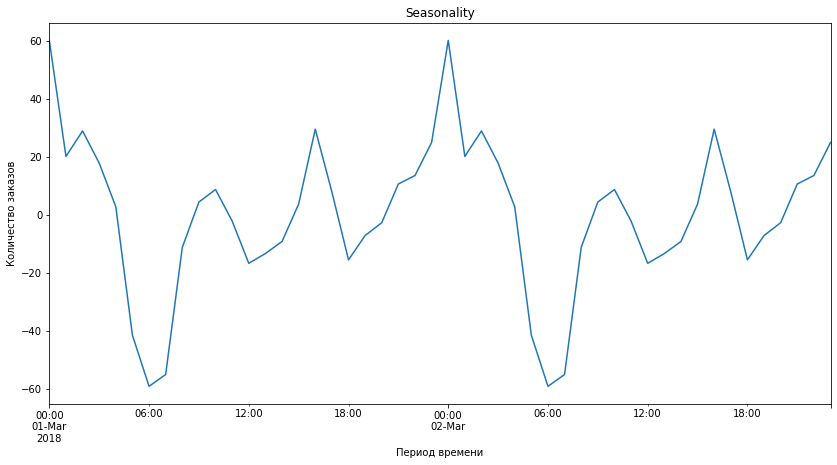

In [24]:
decomposed_day = seasonal_decompose(data)

plt.figure(figsize=(14, 7))
decomposed_day.seasonal['2018-03-01':'2018-03-2'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Количество заказов')
plt.xlabel('Период времени')
plt.show()

Рост количества заказов приходится на 10 утра, 16 часов вечера и пик заказов приходится на 12 часов ночи, минимальное число заказов приходится на 6:00.

## Обучение
___

Разделим данные на обучающую и тестовую:

In [25]:
train, test = train_test_split(new_data, shuffle=False, test_size=0.1)
train = train.dropna()

In [26]:
features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

Проведем обучение различными моделями:

### Линейная регрессия

In [27]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)
print(f"RMSE обучающей выборки: {(mean_squared_error(model.predict(features_train), target_train)):.1f}")

RMSE обучающей выборки: 929.0
CPU times: user 56 ms, sys: 28.3 ms, total: 84.3 ms
Wall time: 32.6 ms


Показатель `RMSE линейной регресси` = 929.

### Модель случайного леса

Создадим функцию для подбора гиперпараметров методом `GridSearchCV`:

In [28]:
def fit_model(estimator, param_grid, features, target):
    model = GridSearchCV(estimator=estimator, 
                         param_grid=param_grid, 
                         cv=TimeSeriesSplit(n_splits=5),
                         scoring='neg_root_mean_squared_error')

    model.fit(features_train, target_train)

    best_index = model.best_index_
    best_rmse = round(model.cv_results_['mean_test_score'][best_index], 1)

    print(f"Best RMSE: {abs(best_rmse)}")
    print(f"Best params: {model.best_params_}")

    return model.best_estimator_

Обучим модель случайного леса:

In [29]:
%%time
rf_param_grid = {
    'n_estimators': list(range(100, 301, 20)),
    "max_depth": list(range(5, 15, 3)),
}

rf_best_model = fit_model(
    estimator=RandomForestRegressor(random_state=12345),
    param_grid=rf_param_grid,
    features=features_train,
    target=target_train
)

Best RMSE: 25.2
Best params: {'max_depth': 14, 'n_estimators': 300}
CPU times: user 2min 40s, sys: 595 ms, total: 2min 41s
Wall time: 2min 41s


Показатель `RMSE случайного леса` = 25.2 при количестве деревьев = 300 и глубине дерева = 14.

### Модель LGBMRegressor

In [30]:
%%time
lgbm_param_grid = {
    "n_estimators": range(230, 301, 20), 
    "max_depth": range(5, 9, 3),
    'learning_rate': [0.01, 0.05, 0.1]
}

lgbm_best_model = fit_model(
    estimator=LGBMRegressor(random_state=12345),
    param_grid=lgbm_param_grid,
    features=features_train,
    target=target_train
)

Best RMSE: 25.2
Best params: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 230}
CPU times: user 1min 30s, sys: 5.33 s, total: 1min 36s
Wall time: 12.4 s


Показатель `RMSE LGBMRegressor` = 25.2 при количестве деревьев = 230 и глубине дерева = 8 и learning_rate = 0.05.

### Модель CatBoostRegressor

In [31]:
%%time
catboost_param_grid = {
    "iterations": range(190, 301, 20),
    "learning_rate": [0.05, 0.1, 0.15],
    "depth": range(5, 15, 3)
}

catboost_best_model = fit_model(
    estimator=CatBoostRegressor(random_state=12345, verbose=False),
    param_grid=catboost_param_grid,
    features=features_train,
    target=target_train
)

Best RMSE: 25.1
Best params: {'depth': 5, 'iterations': 270, 'learning_rate': 0.1}
CPU times: user 51min 52s, sys: 7min 37s, total: 59min 30s
Wall time: 21min 58s


Показатель `RMSE CatBoostRegressor` = 25.1 при количестве деревьев = 270, глубине дерева = 5 и learning_rate = 0.1.

Лучший показатель `RMSE` выдала модель `CatBoostRegressor` с показателем `RMSE` = 25.1, на ней мы и протестируем наши данные.

## Тестирование
___

Проверим качество нашей модели:

In [32]:
predict = catboost_best_model.predict(features_test)

print(f"RMSE на тестовой: {mean_squared_error(target_test, predict) ** 0.5:.1f}")

RMSE на тестовой: 45.3


## Вывод
___

Целью нашего исследования было создание модели для предсказания количества заказов такси на следующий час. В нашем распоряжении были историчекие данные за полгода о заказах такси в аэропортах.

В процессе работы было рассмотрено четыре модели обучения: линейная регрессия, случайный лес, LightGBM и CatBoost. Среди этих моделей по метрике RMSE лучшей оказалась CatBoostRegressor с параметрами: 'depth' = 5, 'iterations' = 270, 'learning_rate' = 0.1. На тестовой выборке лучшая модель показала RMSE = 45.3.